In [32]:
from Psychoacoustics.psyacloss_torch import *
import s3tokenizer
import torch
import matplotlib.pyplot as plt
import torchaudio
from IPython.display import Audio
tokenizer = s3tokenizer.load_model("speech_tokenizer_v2_25hz").cuda() 
tokenizer.train()

S3TokenizerV2(
  (encoder): AudioEncoderV2(
    (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-5): 6 x ResidualAttentionBlock(
        (attn): FSMNMultiHeadAttention(
          (query): Linear(in_features=1280, out_features=1280, bias=True)
          (key): Linear(in_features=1280, out_features=1280, bias=False)
          (value): Linear(in_features=1280, out_features=1280, bias=True)
          (out): Linear(in_features=1280, out_features=1280, bias=True)
          (fsmn_block): Conv1d(1280, 1280, kernel_size=(31,), stride=(1,), groups=1280, bias=False)
          (pad_fn): ConstantPad1d(padding=(15, 15), value=0.0)
        )
        (attn_ln): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Line

In [10]:
def optimize_input_representation_v2(path, ref_path, strength = 0.01, num_steps=500, lr=0.001,    
    psy_weight = 0.1, output=True):
    
    x = s3tokenizer.load_audio(path)
    loss_history = []
    original_x = x.clone().detach().cuda()
    
    ref_x = s3tokenizer.load_audio(ref_path)
    assert ref_x.shape >= x.shape
    ref_x = ref_x[:x.shape[0]]
    mels , mels_lens = s3tokenizer.padding([s3tokenizer.log_mel_spectrogram(ref_x)])
    mel = mels.cuda()
    hidden_ref, _ = tokenizer.encoder(mel, mels_lens.to(mel.device))
    
    max_amp = torch.max(torch.abs(original_x))
    eps = strength * max_amp
    
    w_init = torch.zeros_like(original_x).cuda()
    w = torch.nn.Parameter(w_init)
    
    optimizer = torch.optim.AdamW([w], lr=lr)
    
    
    for step in range(num_steps):
        optimizer.zero_grad()
        
        x_transformed = x.cuda() + eps * torch.tanh(w)
        
        mels , mels_lens = s3tokenizer.padding([s3tokenizer.log_mel_spectrogram(x_transformed)])
        mel = mels.cuda()
        hidden, _ = tokenizer.encoder(mel, mels_lens.to(mel.device))
        
        loss = torch.nn.functional.mse_loss(hidden, hidden_ref)
        psy_loss = percloss(x_transformed.cuda(), original_x.cuda(), 16000)
        loss += psy_weight * psy_loss
        
        loss_history.append(loss.item())

        loss.backward(retain_graph=True)

        optimizer.step()
    

        if step % 5 == 0 and output:
            print(f"Step {step}, Loss: {loss.item()}")

    x_final = (original_x + eps * torch.tanh(w)).detach()
    return x_final, loss_history

In [37]:
path1 = "trail_ds/6319/6319_1.wav"
path2 = "libri_long.wav"
wav_path1 = "external_repos/CosyVoice/audios/5338_2.wav"
wav_path2 = "external_repos/CosyVoice/audios/male_short.wav"

torch.Size([77440]) torch.Size([77440])
Step 0, Loss: 0.20112736523151398
Step 5, Loss: 0.19156578183174133
Step 10, Loss: 0.1844809353351593
Step 15, Loss: 0.17886629700660706
Step 20, Loss: 0.1742599904537201
Step 25, Loss: 0.17026713490486145
Step 30, Loss: 0.16666273772716522
Step 35, Loss: 0.1633337438106537
Step 40, Loss: 0.16021482646465302
Step 45, Loss: 0.15735282003879547
Step 50, Loss: 0.15482482314109802
Step 55, Loss: 0.15254448354244232
Step 60, Loss: 0.15041586756706238
Step 65, Loss: 0.14843490719795227
Step 70, Loss: 0.14656849205493927
Step 75, Loss: 0.14481221139431
Step 80, Loss: 0.14309757947921753
Step 85, Loss: 0.14145265519618988
Step 90, Loss: 0.139867901802063
Step 95, Loss: 0.1383543312549591
Step 100, Loss: 0.13688863813877106
Step 105, Loss: 0.13550874590873718
Step 110, Loss: 0.13424332439899445
Step 115, Loss: 0.13310569524765015
Step 120, Loss: 0.132032573223114
Step 125, Loss: 0.1310347020626068
Step 130, Loss: 0.13009490072727203
Step 135, Loss: 0.1291

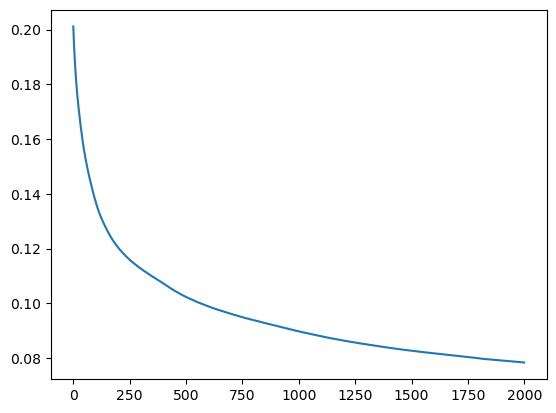

In [46]:
x_adv,loss = optimize_input_representation_v2(path1, path2, strength=0.05, num_steps=2000, psy_weight=0.1)
plt.plot(loss)

In [47]:
x_np = x_adv.cpu().detach().numpy()
torchaudio.save("audios/adv_005001_psy.wav", x_adv.cpu().unsqueeze(0), 16000)
Audio(x_np, rate=16000)

In [30]:
x = s3tokenizer.load_audio(path1)
print(x)

tensor([0.0006, 0.0011, 0.0010,  ..., 0.0052, 0.0046, 0.0052])
